## Importing the necessary modules

In [1]:
import os, math, itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

C:\Users\nixon\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Loading the dataset and converting the class labels to int values (0s and 1s)

In [2]:
# Classes for mapping flux values
goes_classes = ['quiet', 'A', 'B', 'C', 'M', 'X']

def flux_to_class(f: float, only_main=False):
    decade = int(min(math.floor(math.log10(f)), -4))
    main_class = goes_classes[decade + 9] if decade >= -8 else 'quiet'
    sub_class = str(round(10 ** -decade * f)) if main_class != 'quiet' and only_main != True else ''
    return main_class + sub_class

def create_simple_image_set(phase):
    df = pd.read_csv(f'./sdobenchmark_full/{phase}/meta_data.csv', sep=",", parse_dates=["start", "end"], index_col="id")
    df = df.dropna()  # Drop missing IDs
    new_df = {'id': [], 'label': [], 'img': []}

    for row in df.iterrows():
        try:
            ar_nr, p = row[0].split("_", 1)
        except Exception:
            continue

        img_path = os.path.join('./sdobenchmark_full/', phase, ar_nr, p)
        if not os.path.isdir(img_path):
            continue

        for img_name in os.listdir(img_path):
            if img_name.endswith('_magnetogram.jpg'):
                new_df['id'].append(row[0] + '-' + img_name.split('__')[0])
                new_df['label'].append(flux_to_class(row[1]['peak_flux'], only_main=True))

                im = Image.open(os.path.join(img_path, img_name))
                im = im.crop((44, 44, 212, 212))
                im = im.resize((28, 28), Image.ANTIALIAS)
                im = np.array(im) / 255.0
                im = im.reshape(28, 28, 1)
                new_df['img'].append(im)

    return pd.DataFrame(new_df)

# Load datasets
train = create_simple_image_set('training')
test = create_simple_image_set('test')

# Convert labels to binary (X or M => 1)
Y_train = ((train["label"] == 'X') | (train["label"] == 'M')).astype(int)
X_train = np.asarray(list(train['img']))
Y_val = ((test["label"] == 'X') | (test["label"] == 'M')).astype(int)
X_val = np.asarray(list(test['img']))
del train, test

## Model training and compiling

In [14]:
# Compute class weights
class_weight_dict = {0: 1.0, 1: 3.0}
print(f"Using manually set class weights: {class_weight_dict}")

# CNN Model
model = Sequential([
    Conv2D(32, (5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1)),
    Conv2D(32, (5, 5), padding='Same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='Same', activation='relu'),
    Conv2D(64, (3, 3), padding='Same', activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='loss', patience=4, min_delta=1e-8,
                                 verbose=1, factor=0.5, min_lr=1e-5)

# Data Augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,

    vertical_flip=True
)
datagen.fit(X_train)

# Train the model
history = model.fit(datagen.flow(X_train, Y_train, batch_size=128),
          epochs=10,
          steps_per_epoch=len(X_train) // 128,
          validation_data=(X_val, Y_val),  # <--- Add this!
          class_weight=class_weight_dict,
          callbacks=[lr_reduction],
          verbose=1)


Using manually set class weights: {0: 1.0, 1: 3.0}
Epoch 1/10
255/255 [==============================] - 64s 245ms/step - loss: 0.4807 - accuracy: 0.9350 - val_loss: 0.4320 - val_accuracy: 0.8173 - lr: 0.0010
Epoch 2/10
255/255 [==============================] - 65s 254ms/step - loss: 0.4302 - accuracy: 0.9296 - val_loss: 0.4969 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 3/10
255/255 [==============================] - 68s 265ms/step - loss: 0.4175 - accuracy: 0.9256 - val_loss: 0.4170 - val_accuracy: 0.8222 - lr: 0.0010
Epoch 4/10
255/255 [==============================] - 67s 262ms/step - loss: 0.4042 - accuracy: 0.9233 - val_loss: 0.4836 - val_accuracy: 0.7652 - lr: 0.0010
Epoch 5/10
255/255 [==============================] - 68s 267ms/step - loss: 0.4036 - accuracy: 0.9255 - val_loss: 0.3940 - val_accuracy: 0.8274 - lr: 0.0010
Epoch 6/10
255/255 [==============================] - 70s 276ms/step - loss: 0.3976 - accuracy: 0.9246 - val_loss: 0.3940 - val_accuracy: 0.8153 - lr: 0.0010
E

## Predicting test images

In [4]:
# Evaluate
Y_pred = (model.predict(X_val) > 0.45).astype(int)

109/109 [==============================] - 2s 14ms/step


## Confusion matrix plot

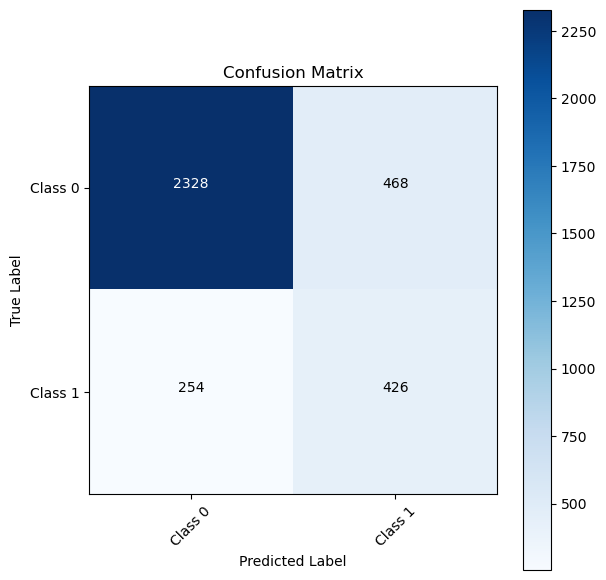

              precision    recall  f1-score   support

     Class 0       0.90      0.83      0.87      2796
     Class 1       0.48      0.63      0.54       680

    accuracy                           0.79      3476
   macro avg       0.69      0.73      0.70      3476
weighted avg       0.82      0.79      0.80      3476



In [5]:
# Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

cm = confusion_matrix(Y_val, Y_pred)
plot_confusion_matrix(cm, classes=['Class 0', 'Class 1'])

# Classification Report
print(classification_report(Y_val, Y_pred, target_names=['Class 0', 'Class 1']))


109/109 [==============================] - 1s 13ms/step


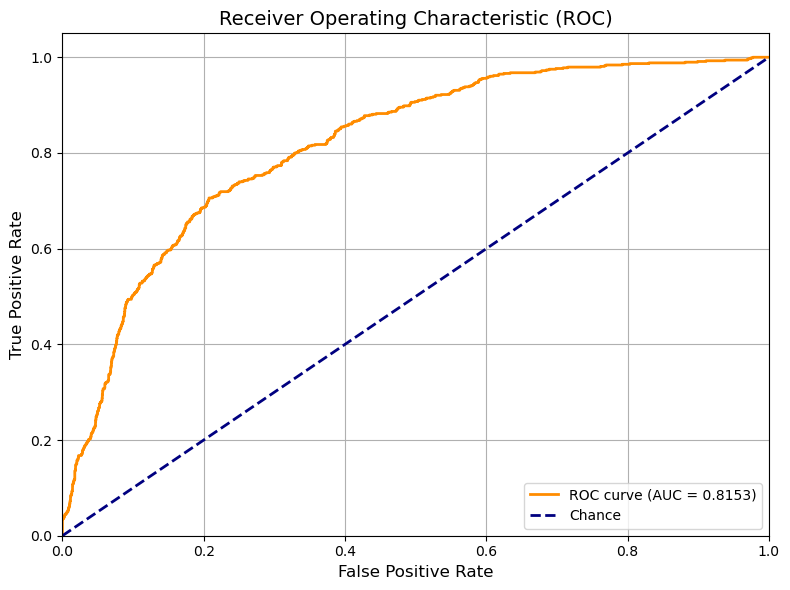

In [6]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities (not class labels)
Y_pred_proba = model.predict(X_val).ravel()  # Flatten if needed

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(Y_val, Y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## Save the model

In [7]:
model.save("solar_flare_classifier.h5")

C:\Users\nixon\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Generate true positives and true negatives

109/109 [==============================] - 2s 14ms/step


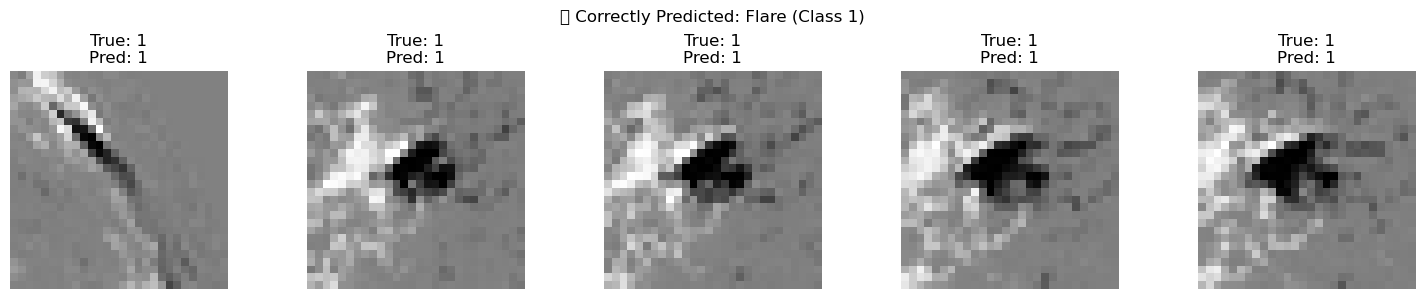

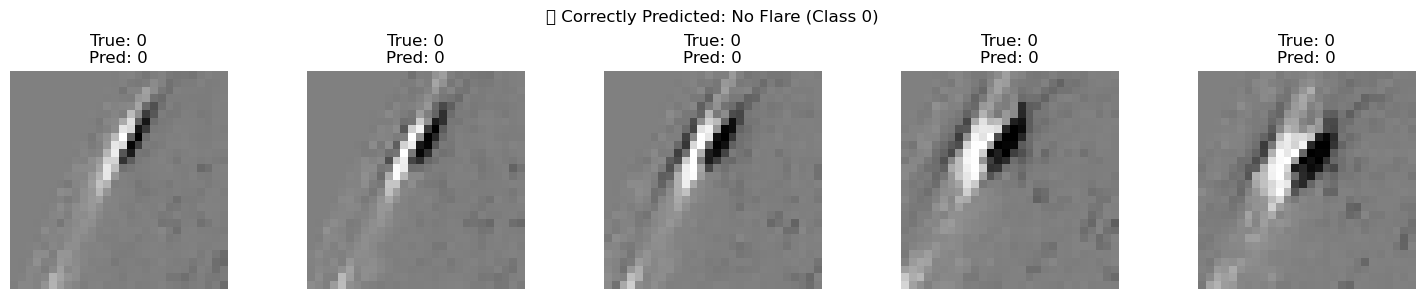

In [18]:
import matplotlib.pyplot as plt

# Get model predictions
Y_pred_proba = model.predict(X_val).ravel()
Y_pred = (Y_pred_proba > 0.5).astype(int)

# Store matched true positives and true negatives
correct_flare_idxs = np.where((Y_val == 1) & (Y_pred == 1))[0]
correct_noflare_idxs = np.where((Y_val == 0) & (Y_pred == 0))[0]

# Helper function to display images
def plot_images(indices, title, max_images=5):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices[:max_images]):
        plt.subplot(1, max_images, i + 1)
        plt.imshow(X_val[idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {Y_val[idx]}\nPred: {Y_pred[idx]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot a few correctly predicted 'flare' and 'no flare' images
plot_images(correct_flare_idxs, title="✅ Correctly Predicted: Flare (Class 1)")
plot_images(correct_noflare_idxs, title="✅ Correctly Predicted: No Flare (Class 0)")

## Store sample test images in a directory for further usage in UI

In [19]:
import matplotlib.pyplot as plt
import os

# Create export directory
export_dir = "classified_images"
os.makedirs(export_dir, exist_ok=True)

def save_pred_images(indices, title_prefix, max_images=5):
    for i, idx in enumerate(indices[:max_images]):
        fig, ax = plt.subplots()
        ax.imshow(X_val[idx].reshape(28, 28), cmap='gray')
        ax.set_title(f"True: {Y_val[idx]} | Pred: {Y_pred[idx]}")
        ax.axis('off')

        filename = f"{title_prefix}_{i}_true{Y_val[idx]}_pred{Y_pred[idx]}.png"
        fig.savefig(os.path.join(export_dir, filename), bbox_inches='tight')
        plt.close(fig)

# Save correct flare (TP) images
save_pred_images(correct_flare_idxs, title_prefix="correct_flare")

# Save correct no-flare (TN) images
save_pred_images(correct_noflare_idxs, title_prefix="correct_noflare")

# Save false positives (pred=1, true=0)
false_pos_idxs = np.where((Y_val == 0) & (Y_pred == 1))[0]
save_pred_images(false_pos_idxs, title_prefix="false_positive")

# Save false negatives (pred=0, true=1)
false_neg_idxs = np.where((Y_val == 1) & (Y_pred == 0))[0]
save_pred_images(false_neg_idxs, title_prefix="false_negative")

print(f"Exported prediction images to folder: '{export_dir}'")

Exported prediction images to folder: 'classified_images'


## Plot for training accuracy and training loss

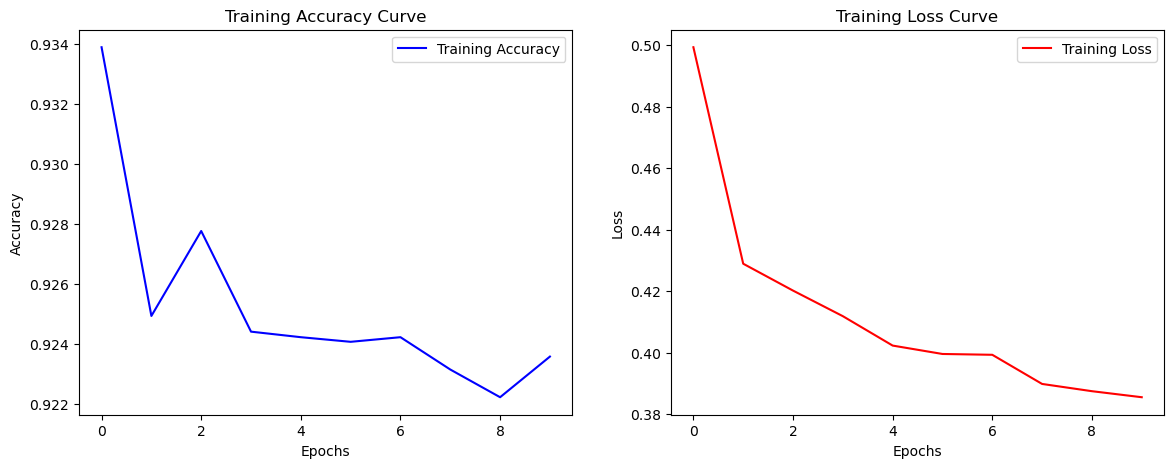

In [12]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss curves
def plot_training_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    ax[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax[0].set_title('Training Accuracy Curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Plot loss
    ax[1].plot(history.history['loss'], label='Training Loss', color='red')
    ax[1].set_title('Training Loss Curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

# Call the function with the training history object
plot_training_curves(history)